# Baby Steps into Optical Mark Recognition (OMR) with Python and OpenCV

Optical mark recognition is the attempt to scan marks on a sheet of paper and convert them to useful data. Like bubbles you fill on a multiple choice exam.

OMR is not OCR. OCR is character recognition, marks are typically placed on templates that we recognize and turn into data.


In [65]:
# Juypter Notebooks are frustrating
from IPython.display import HTML
HTML('<style>{}</style>'.format(open('custom.css').read()))

In [27]:
import matplotlib.pyplot as plt
import numpy
import numpy as np
from IPython.display import display
from PIL import Image
import cv2 as cv
import sys
import matplotlib

In [28]:
%matplotlib inline

In [31]:
matplotlib.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 200


In [ ]:
# OMR Setup

# Template Matching

Template matching is pretty simple and pretty powerful.

# Strengths

* Given assumptions it is very robust
* It is very fast when done right (openCV, numpy, etc.)
* It is so fast you can apply it many times

# Weaknesses

* Template matching is not rotation invariant. Heavy rotation is not easy.
* Template matching is not flip or mirror invariant.
* Template matching is not scale invariant.

In [49]:
def flip_image(img):
    w, h = img.shape[::-1]
    center = (w/2,h/2)
    M = cv.getRotationMatrix2D(center, 180, 1.0)
    imgUP = cv.warpAffine(img, M, (w, h))
    return imgUP

def find_template(input_img, template_img):
    img_gray = cv.cvtColor(input_img, cv.COLOR_BGR2GRAY)
    res = cv.matchTemplate(img_gray,template,cv.TM_CCOEFF_NORMED)
    print(input_img.shape,res.shape) # it makes a smaller image
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    pt = max_loc
    sub = img_gray[pt[1]:pt[1]+h,pt[0]:pt[0]+w]
    return (sub, pt, res)

def grayscale(img):
    return cv.cvtColor(img, cv.COLOR_BGR2GRAY)

(1100, 850, 3) (825, 650)
(578, 61)


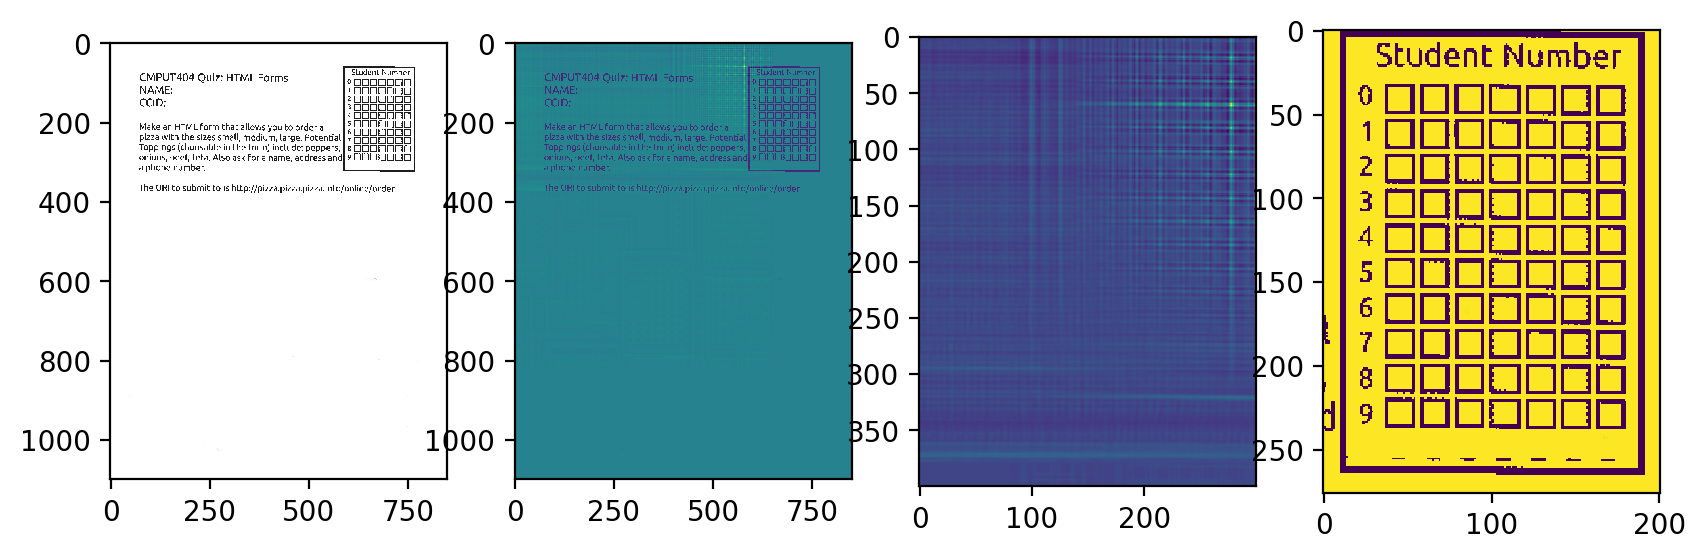

In [64]:
# Demo of template matching working

img_rgb = cv.imread("safe-blanks/pg_0053.pdf.png")
template = cv.imread('blank001.png',0)

(sub,pt,res) = find_template(img_rgb, template)
print(pt)
fig=plt.figure(figsize=(10, 5))
fig.add_subplot(1, 4, 1)
img_rgb
plt.imshow(img_rgb)
fig.add_subplot(1, 4, 2)
combo = grayscale(img_rgb).astype('float32')
combo[0:res.shape[0],0:res.shape[1]] += 500*res
plt.imshow(combo )
fig.add_subplot(1, 4, 3)
plt.imshow(res[0:400,300:600])
fig.add_subplot(1, 4, 4)
plt.imshow(sub)
plt.show()

# Tips for improving performance

* If you know the names and numbers you are looking for ahead of time limit the outputs to those. E.g. you know the student numbers in your class.
